large_0: 8
large_1: 12
large_2: 22
large_3: 24
large_4: 33
large_5: 35
large_6: 36
large_7: 38


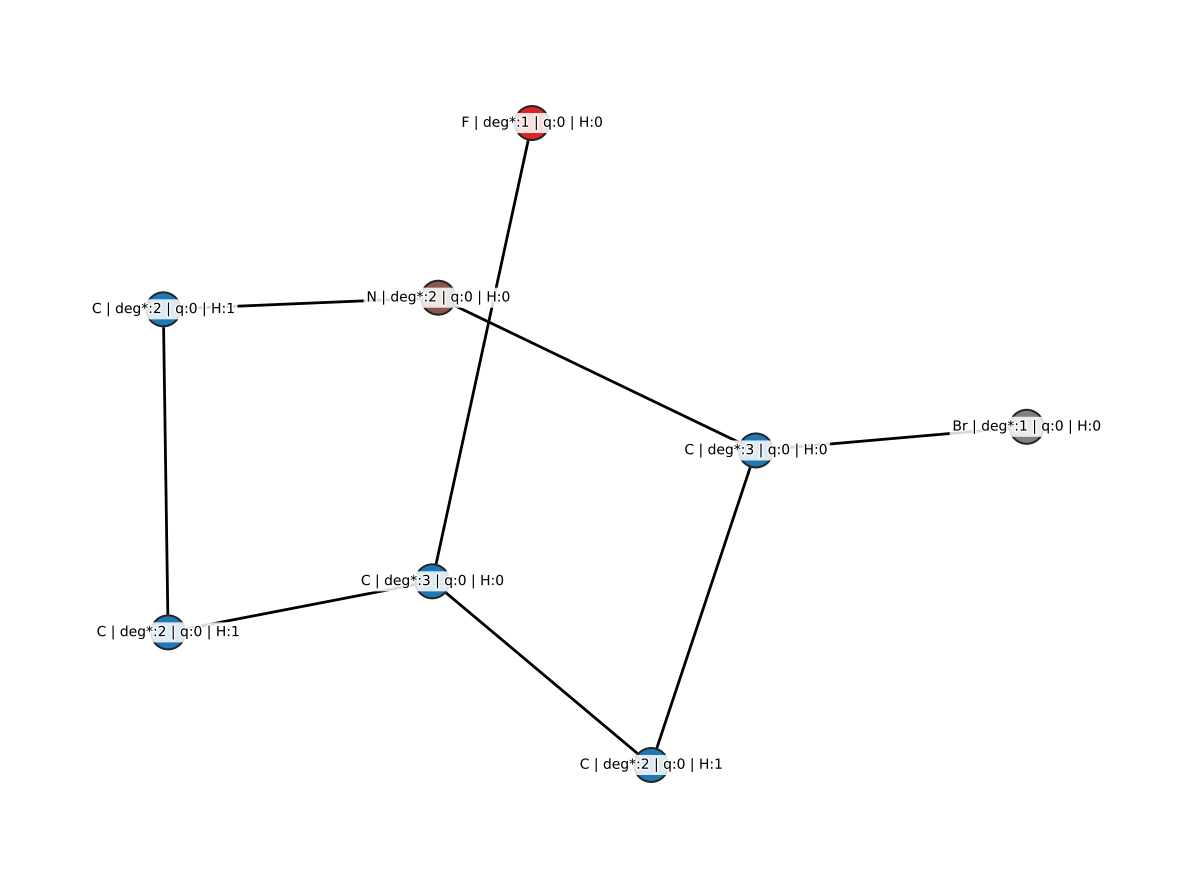

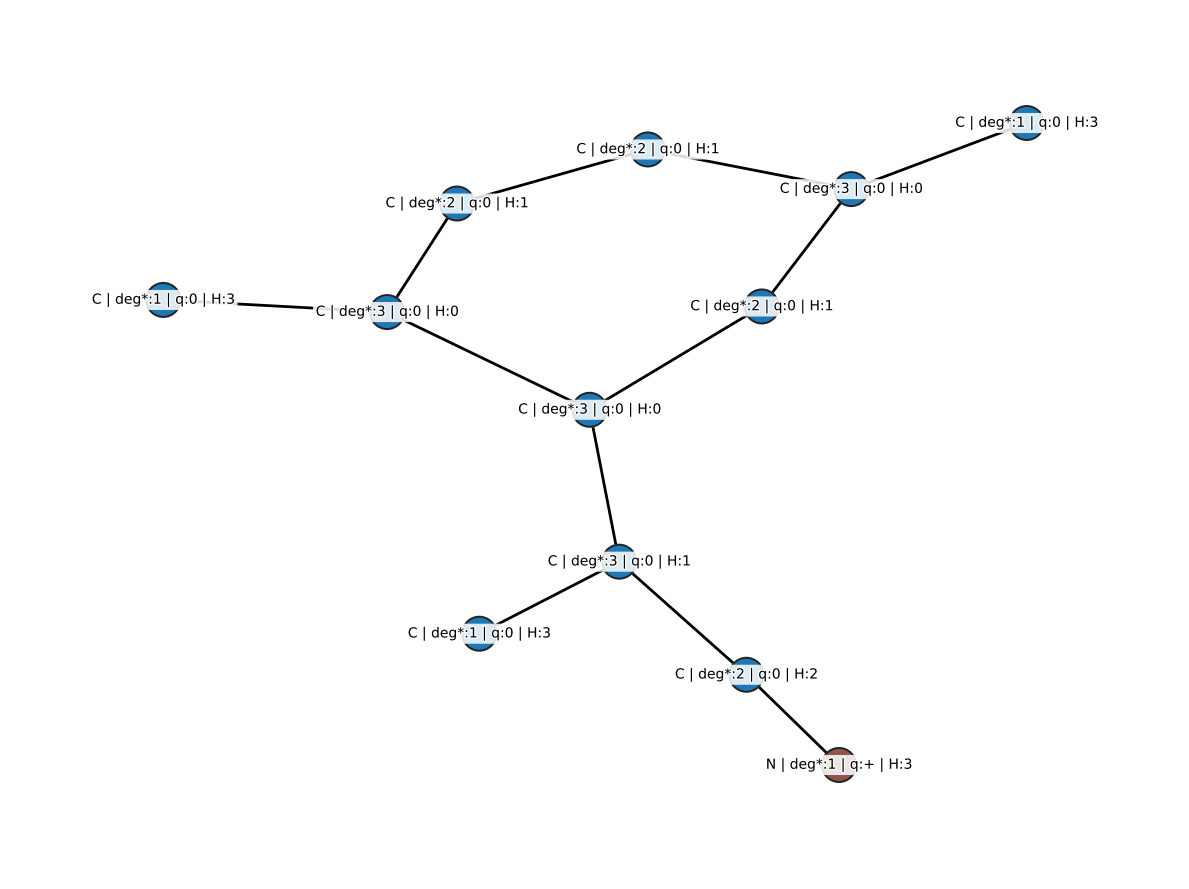

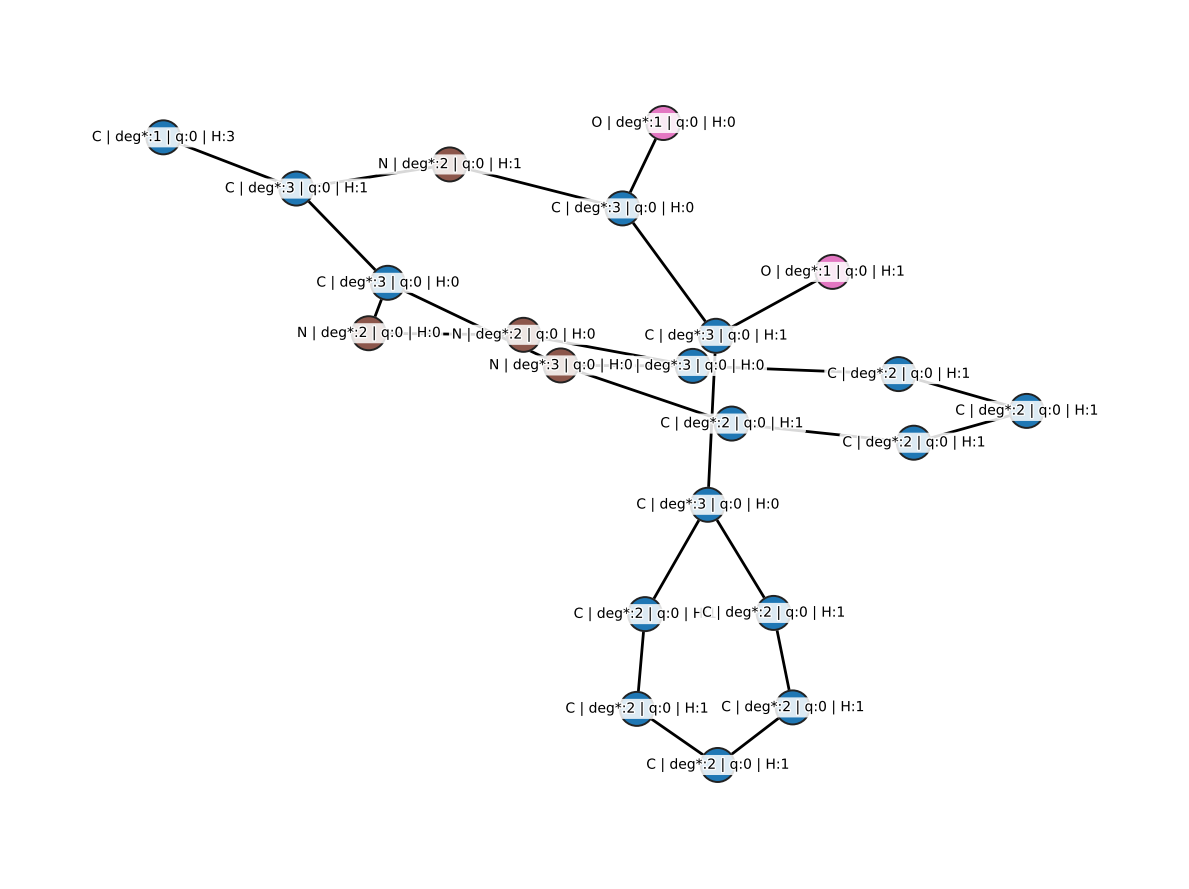

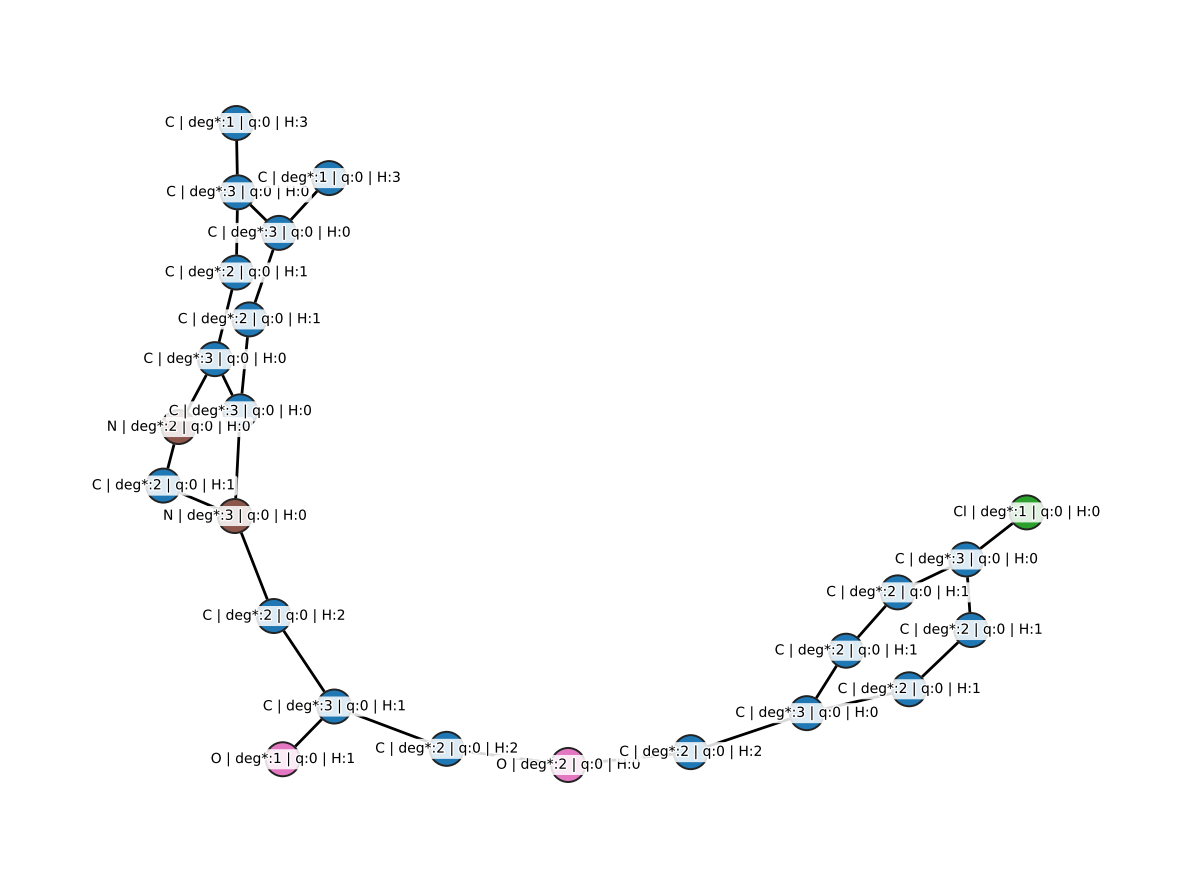

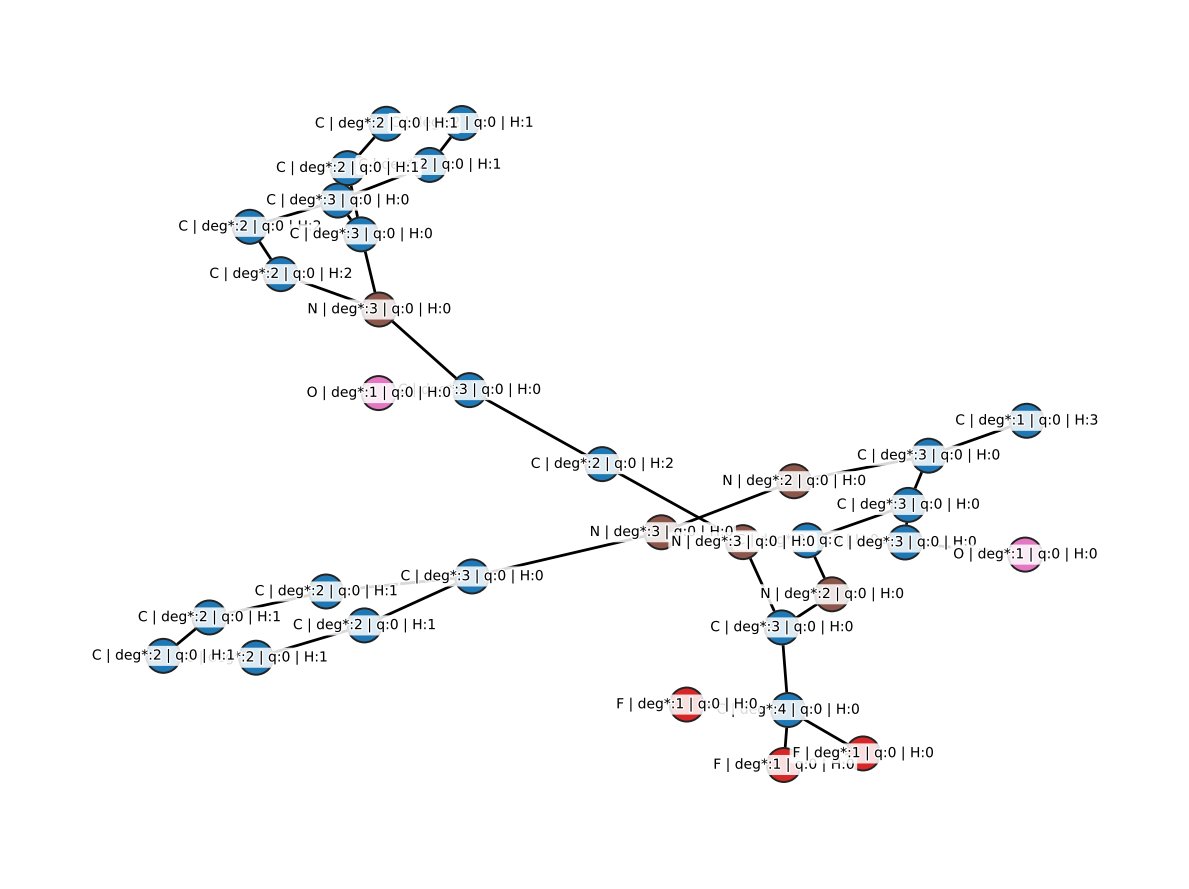

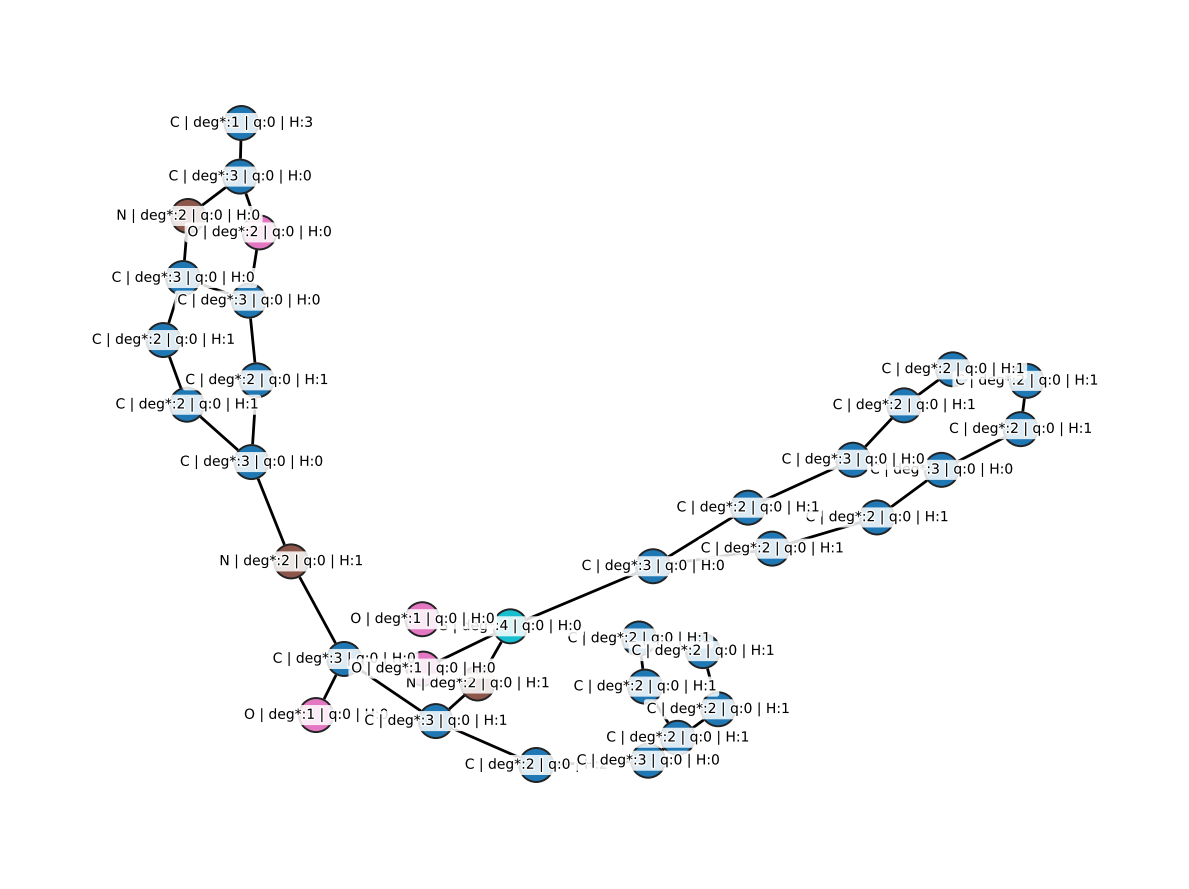

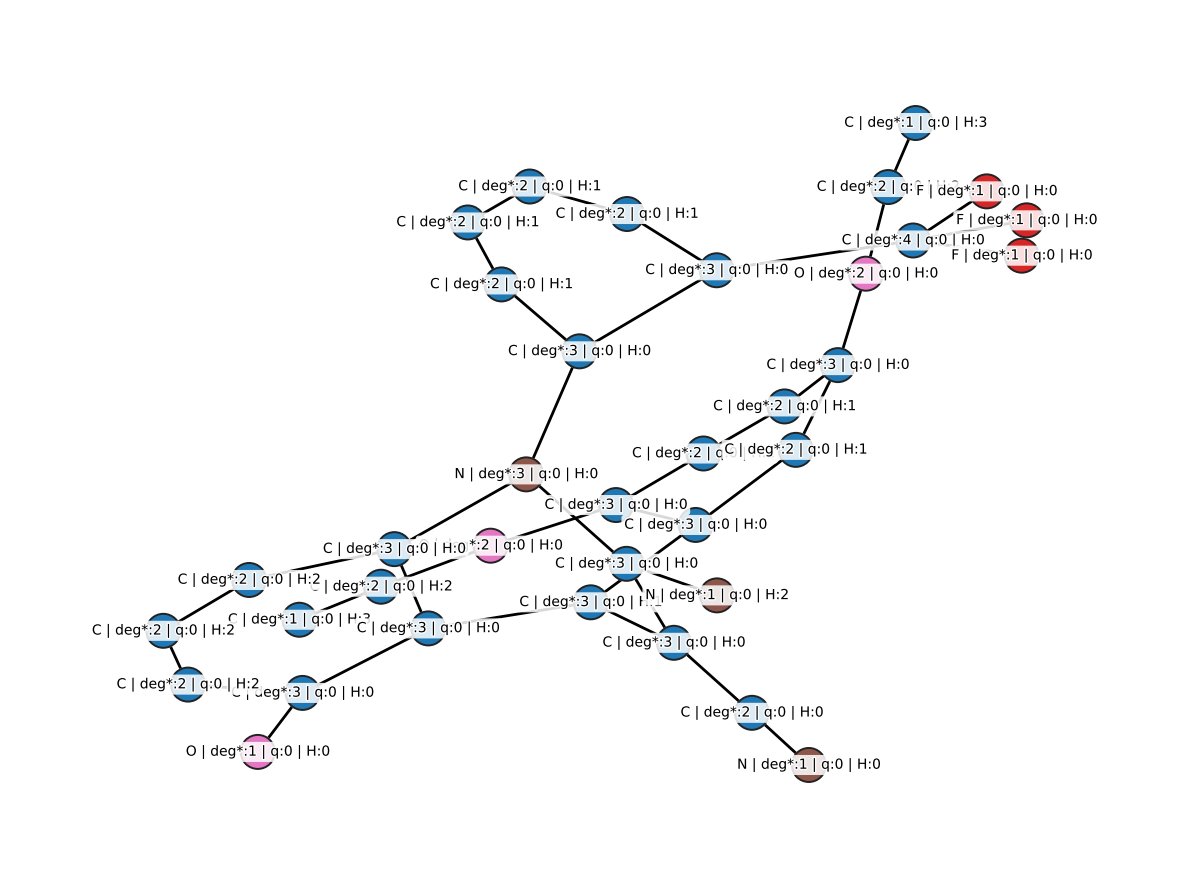

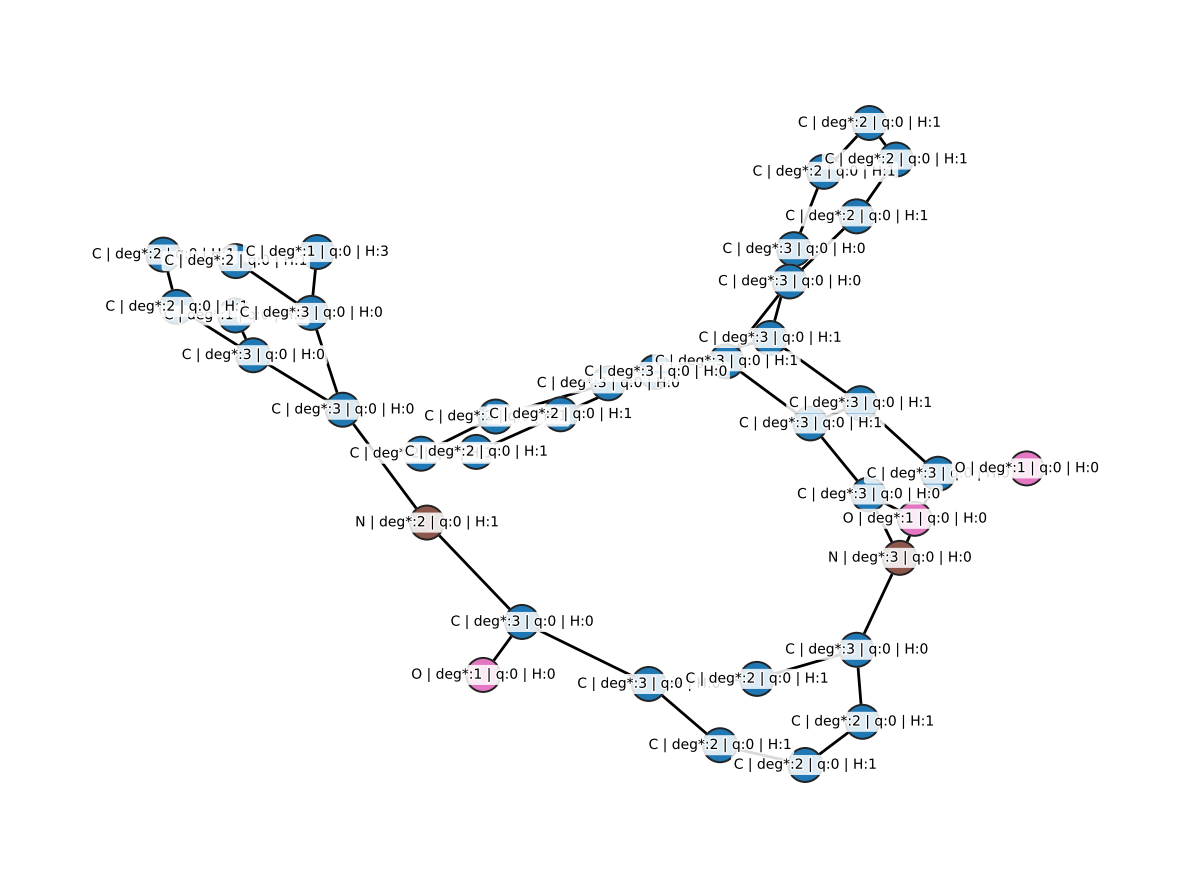

In [1]:
import random
from pathlib import Path

from matplotlib import pyplot as plt

from src.datasets.zinc_smiles_generation import ZincSmiles
from src.utils.chem import draw_mol
from src.utils.utils import DataTransformer
from src.utils.visualisations import draw_nx_with_atom_colorings

# qm9 = QM9Smiles(split="train")
zinc = ZincSmiles(split="train")

# sorted_qm9 = sorted(qm9, key=lambda x: len(x.x))
sorted_zinc = sorted(zinc, key=lambda x: len(x.x))

samples = {
    # "small_1": (sorted_qm9[100], "QM9Smiles"),
    # "small_2": (sorted_qm9[10000], "QM9Smiles"),
    # "small_3": (sorted_qm9[-1], "QM9Smiles"),
    "large_0": (sorted_zinc[10], "ZincSmiles"),
    "large_1": (sorted_zinc[1000], "ZincSmiles"),
    "large_2": (zinc[10], "ZincSmiles"),
    "large_3": (sorted_zinc[-100000], "ZincSmiles"),
    "large_4": (sorted_zinc[-5000], "ZincSmiles"),
    "large_5": (sorted_zinc[-1000], "ZincSmiles"),
    "large_6": (ZincSmiles(split="test")[10], "ZincSmiles"),
    "large_7": (sorted_zinc[-1], "ZincSmiles")
}
examples = []
out = Path() / "examples"
out.mkdir(exist_ok=True, parents=True)
for i, (name, (data, dataset)) in enumerate(samples.items()):
    res = {}
    nx_g = DataTransformer.pyg_to_nx(data)
    print(f"{name}: {nx_g.number_of_nodes()}")
    draw_nx_with_atom_colorings(nx_g, dataset=dataset)
    plt.savefig(out / f"{name}_nx.png")
    mol, _ = DataTransformer.nx_to_mol_v2(nx_g, dataset="qm9" if dataset == "QM9Smiles" else "zinc")
    draw_mol(mol=mol, save_path=str(out / f"{name}_mol.png"), fmt="png")
    node_tuples = [tuple(i) for i in data.x.int().tolist()]
    node_tuples = [(a, b+1, c, d, e) for a, b, c, d, e in node_tuples]
    edge_idxs = [tuple(e) for e in data.edge_index.t().cpu().int().tolist()]
    edge_tuples = [(node_tuples[u], node_tuples[v]) for u, v in edge_idxs]
    the_input = {
        "nodes_multiset": [tuple(e) for e in random.sample(node_tuples, k=len(node_tuples))],
        "edges_multiset": edge_tuples,
    }
    expected_output = {
        "ordered_nodes": node_tuples,
        "associated_edge_idxs": edge_idxs,
    }
    examples.append({
        name: {
            "input": the_input,
            "expected_output": expected_output,
        },
    })

with open(out / "examples_ring_aware.json", "w") as f:
    import json
    json.dump(examples, f, indent=None, separators=(",", ":"))


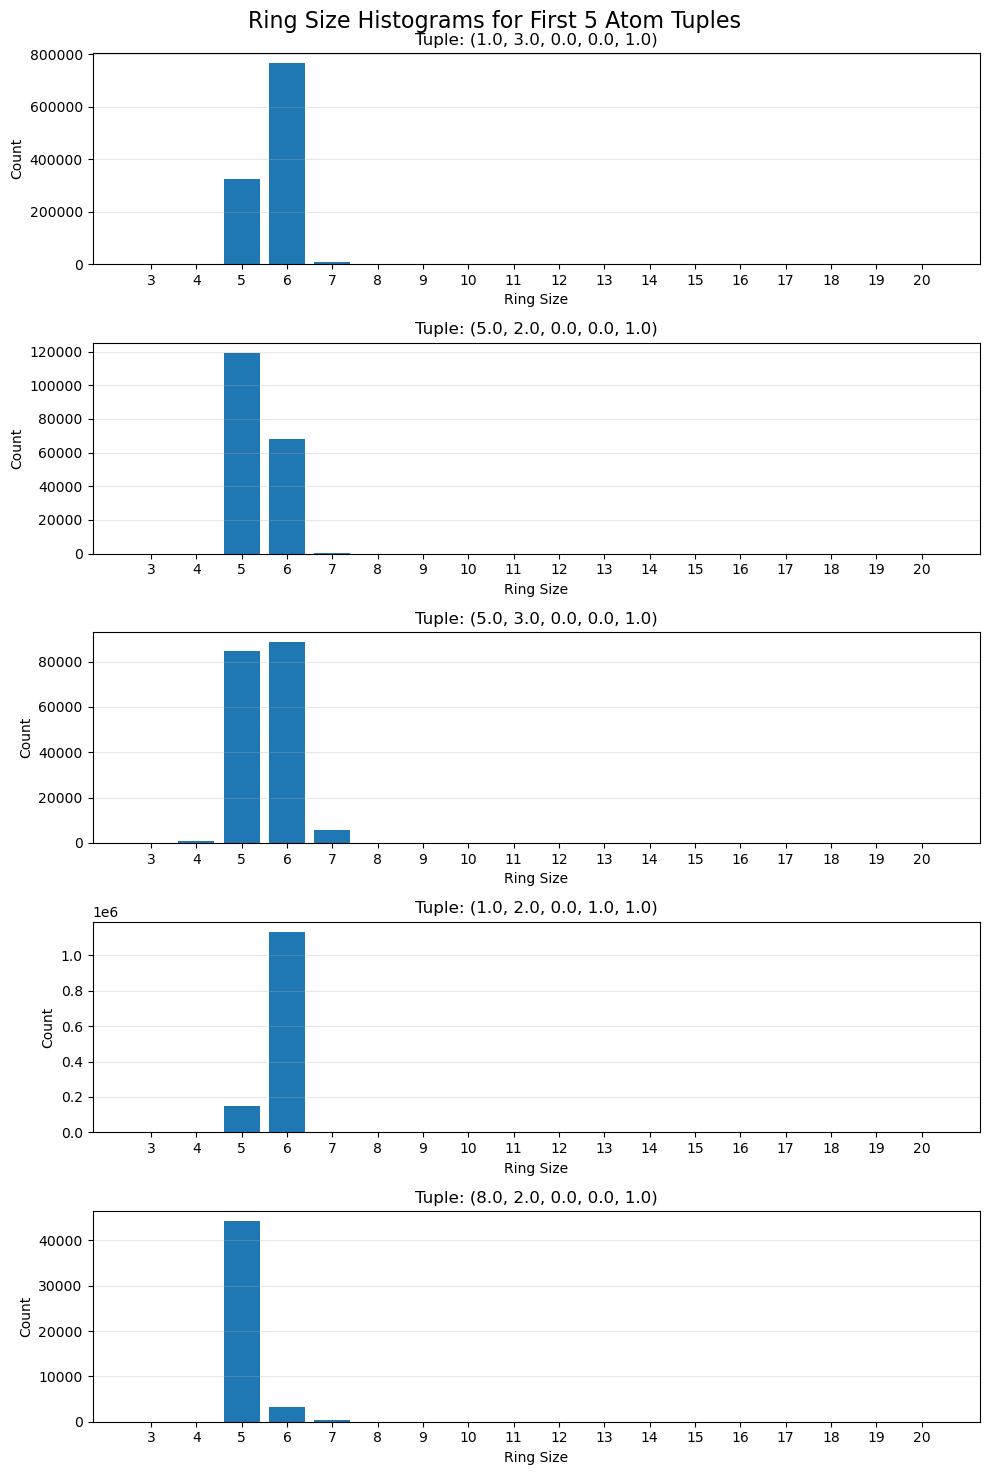


Total unique atom tuples with rings: 27

Ring size distribution across all tuples:
  Ring size 3: 46881
  Ring size 4: 16273
  Ring size 5: 1036792
  Ring size 6: 2609993
  Ring size 7: 58859
  Ring size 8: 3457
  Ring size 9: 57
  Ring size 10: 100
  Ring size 11: 0
  Ring size 12: 220
  Ring size 13: 15
  Ring size 14: 42
  Ring size 15: 75
  Ring size 16: 0
  Ring size 17: 0
  Ring size 18: 134
  Ring size 19: 0
  Ring size 20: 0


In [2]:

from collections import Counter, defaultdict

from rdkit import Chem

from src.datasets.zinc_smiles_generation import ZINC_SMILE_ATOM_TO_IDX

# Initialize ring_histogram as a dictionary of tuples to Counters
ring_histogram = defaultdict(Counter)

# Iterate over all splits
for split in ["train", "test", "valid"]:
    for data in ZincSmiles(split=split):
        mol = Chem.MolFromSmiles(data.smiles)
        for atom in mol.GetAtoms():
            if atom.IsInRing():
                atom_tuple = (
                    float(ZINC_SMILE_ATOM_TO_IDX[atom.GetSymbol()]),
                    float(max(0, atom.GetDegree())),  # [1, 2, 3, 4, 5] -> [0, 1, 2, 3, 4]
                    float(atom.GetFormalCharge() if atom.GetFormalCharge() >= 0 else 2),  # [0, 1, -1] -> [0, 1, 2]
                    float(atom.GetTotalNumHs()),
                    float(atom.IsInRing())
                )
                # Count ring sizes for this atom tuple
                for ring_size in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]:
                    if atom.IsInRingSize(ring_size):
                        ring_histogram[atom_tuple][ring_size] += 1

# Display histograms for first 5 tuples
first_5_tuples = list(ring_histogram.keys())[:5]

fig, axes = plt.subplots(5, 1, figsize=(10, 15))
fig.suptitle('Ring Size Histograms for First 5 Atom Tuples', fontsize=16)

all_ring_sizes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for idx, atom_tuple in enumerate(first_5_tuples):
    counts = [ring_histogram[atom_tuple].get(size, 0) for size in all_ring_sizes]
    axes[idx].bar(all_ring_sizes, counts)
    axes[idx].set_xlabel('Ring Size')
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(f'Tuple: {atom_tuple}')
    axes[idx].set_xticks(all_ring_sizes)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(out / "ring_size_histogram.png")
plt.show()

print(f"\nTotal unique atom tuples with rings: {len(ring_histogram)}")
print(f"\nRing size distribution across all tuples:")
total_ring_counts = Counter()
for counter in ring_histogram.values():
    total_ring_counts.update(counter)
for size in all_ring_sizes:
    print(f"  Ring size {size}: {total_ring_counts.get(size, 0)}")


In [3]:
# with open(out / "ring_histogram.json", "w") as f:
#     import json
#     json.dump(ring_histogram, f, indent=None, separators=(",", ":"))

import pickle

with open("examples/ring_histogram.pkl", "wb") as f:
    pickle.dump(ring_histogram, f)

with open("examples/ring_histogram.pkl", "rb") as f:
    my_dict = pickle.load(f)

print(my_dict)

defaultdict(<class 'collections.Counter'>, {(1.0, 3.0, 0.0, 0.0, 1.0): Counter({6: 765570, 5: 323639, 7: 7588, 4: 485, 8: 197, 12: 20, 10: 17, 18: 16, 9: 10, 15: 8, 14: 7, 13: 6, 3: 6}), (5.0, 2.0, 0.0, 0.0, 1.0): Counter({5: 119258, 6: 67829, 7: 127, 3: 4, 4: 2, 8: 2, 13: 1}), (5.0, 3.0, 0.0, 0.0, 1.0): Counter({6: 88525, 5: 84517, 7: 5863, 4: 668, 8: 142, 3: 24, 18: 4, 12: 3, 9: 3, 10: 2, 15: 1}), (1.0, 2.0, 0.0, 1.0, 1.0): Counter({6: 1134309, 5: 149287, 7: 138, 8: 18, 4: 10, 10: 10, 12: 9, 14: 4, 13: 2}), (8.0, 2.0, 0.0, 0.0, 1.0): Counter({5: 44258, 6: 3341, 7: 381, 8: 11, 4: 6, 14: 4, 9: 3, 3: 3, 13: 2, 18: 1}), (5.0, 2.0, 0.0, 1.0, 1.0): Counter({5: 19415, 6: 11733, 7: 907, 4: 9, 8: 7, 3: 2, 18: 2, 9: 1}), (1.0, 3.0, 0.0, 1.0, 1.0): Counter({6: 97084, 5: 64339, 3: 17526, 7: 4478, 4: 3956, 8: 249, 10: 18, 12: 12, 9: 6, 14: 3, 15: 1}), (1.0, 2.0, 0.0, 2.0, 1.0): Counter({6: 378185, 5: 158923, 7: 34940, 3: 26942, 4: 8517, 8: 2740, 12: 146, 18: 75, 10: 47, 15: 41, 9: 31, 14: 22, 13:

In [7]:
import math
import matplotlib.pyplot as plt

def plot_ring_size_distributions(my_dict: dict, *, normalize: bool = True, ncols: int = 18):
    # Collect the union of all ring sizes across node types, sorted for stable axes
    ring_sizes = sorted({k for ctr in my_dict.values() for k in ctr.keys()})
    n_types = len(my_dict)
    nrows = math.ceil(n_types / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5*ncols, 2.8*nrows), squeeze=False)
    axes = axes.ravel()

    for ax, node_type in zip(axes, sorted(my_dict.keys())):
        ctr = my_dict[node_type]
        counts = [ctr.get(rs, 0) for rs in ring_sizes]
        if normalize:
            total = sum(counts) or 1
            vals = [c / total for c in counts]
            ax.set_ylim(0, 1)
            ax.set_ylabel("proportion")
        else:
            vals = counts
            ax.set_ylabel("count")

        ax.bar(ring_sizes, vals)
        ax.set_xticks(ring_sizes)
        ax.set_xlabel("ring size")
        ax.set_title(str(node_type), fontsize=9)
        ax.grid(axis="y", linestyle="--", alpha=0.3)

    # Hide any empty subplots if keys don't fill the grid
    for j in range(n_types, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Ring size distribution per node type", fontsize=12)
    fig.tight_layout()
    plt.show()

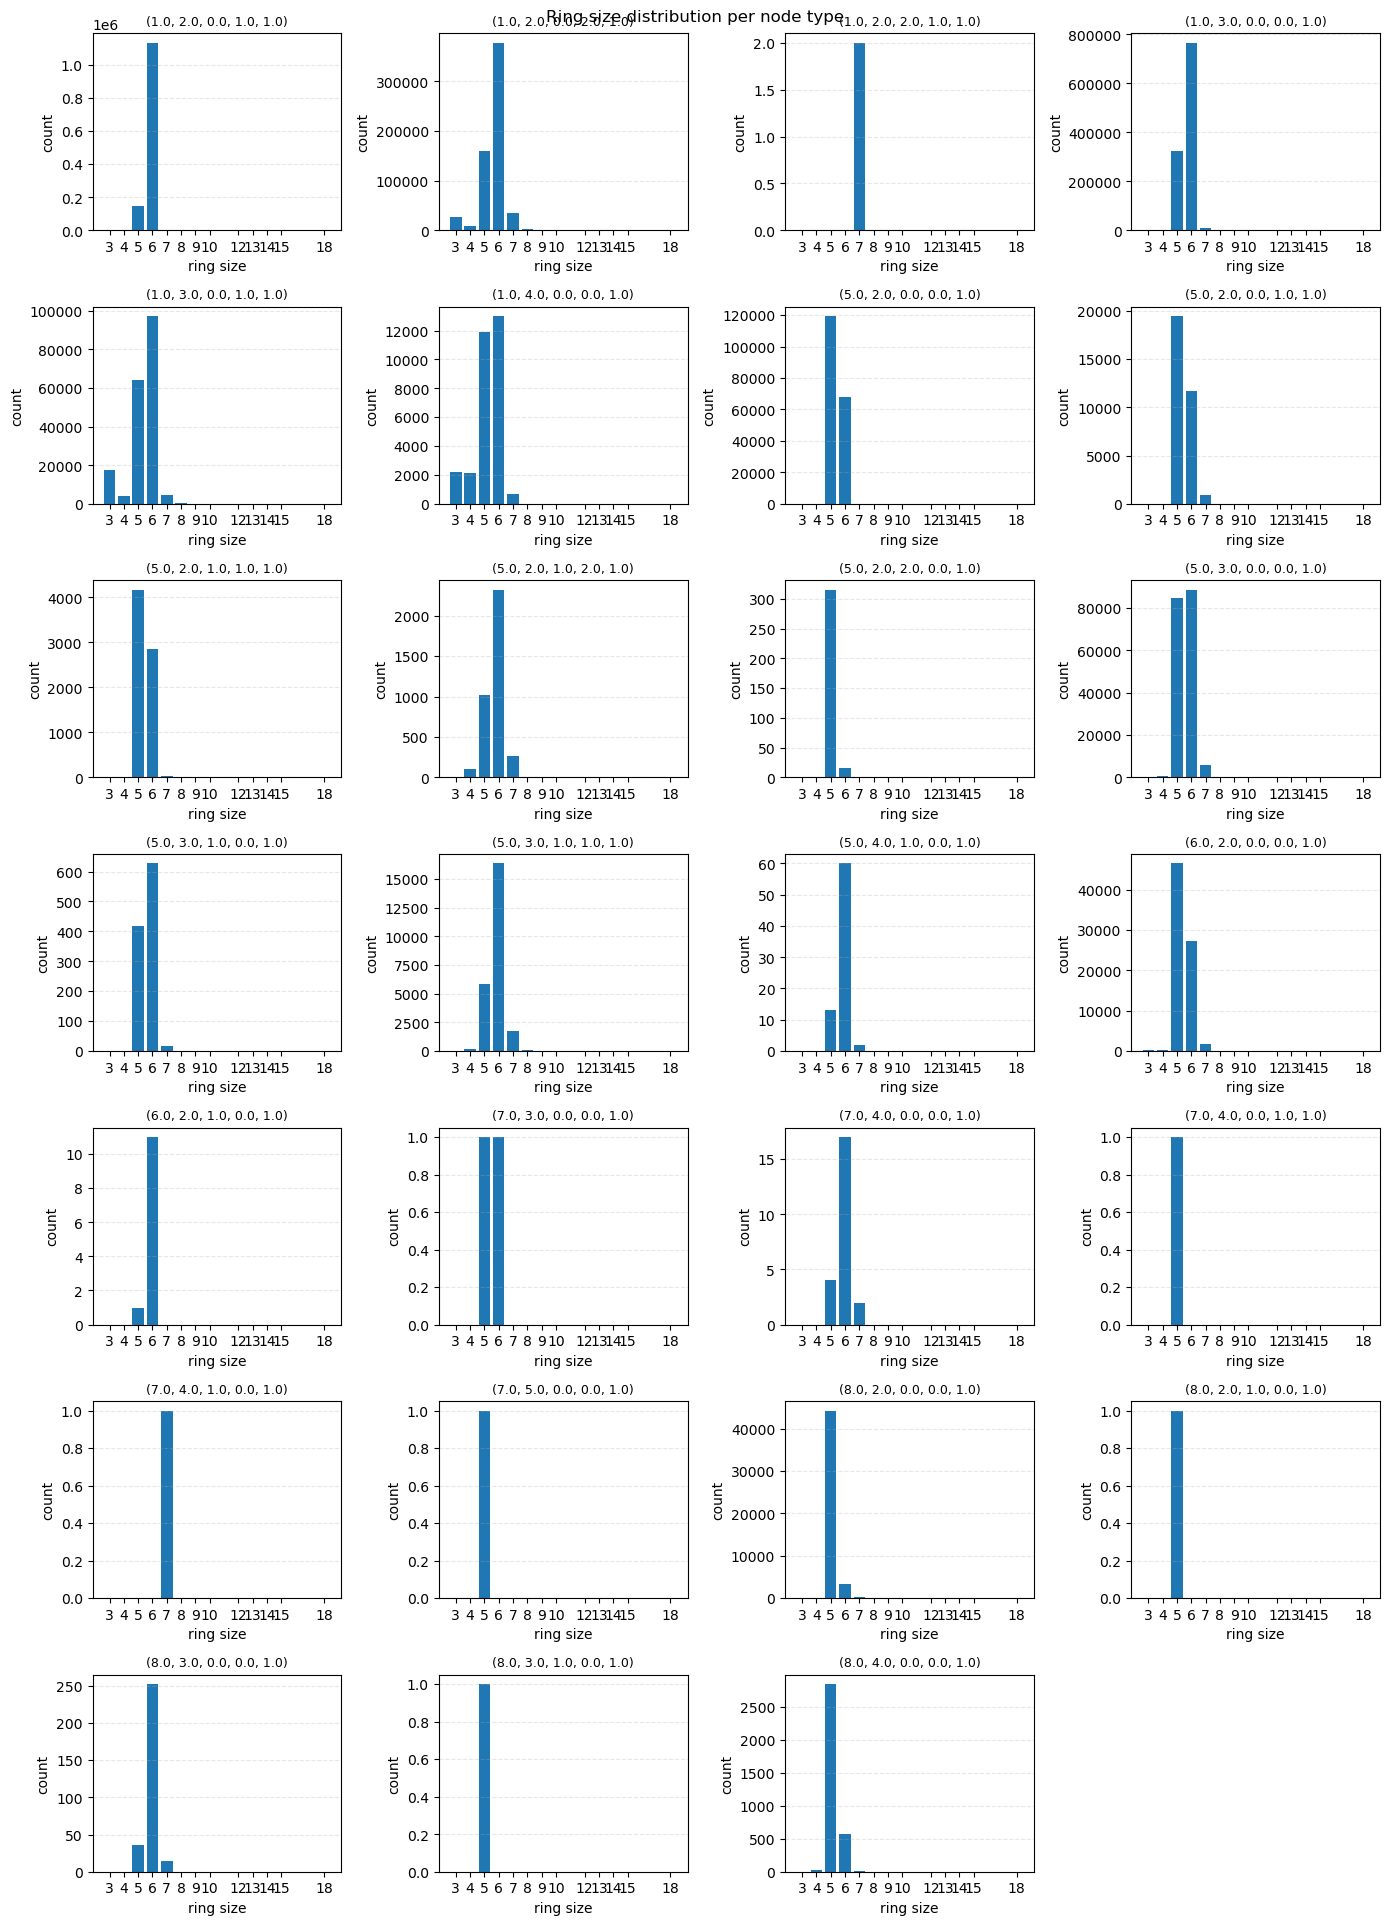

In [8]:
plot_ring_size_distributions(my_dict, normalize=False, ncols=4)